# Peak Read Counts

**Created**: 15 November 2021

## Environment

In [1]:
rm(list=ls())

library(tidyverse)
library(RColorBrewer)
library(data.table)
library(cowplot)
library(Rtsne)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




## Load Data

In [2]:
frip <- read.table("~/gains_team282/epigenetics/calderon_et_al/analysis/atac_seq/peak_frips.tsv", header=T)

frip <- frip %>%
    dplyr::mutate(Sample=sapply(strsplit(Sample_File, "\\."), function(x) x[1])) %>%
    dplyr::select(Sample, Assigned_Reads, Total_Reads, FRiP)

In [3]:
head(frip)

,Sample,Assigned_Reads,Total_Reads,FRiP
,<chr>,<int>,<int>,<dbl>
1,SRR7650746,20104952,50159922,0.4008171
2,SRR7650847,10684470,27711261,0.3855642
3,SRR7650752,20182579,52452020,0.3847817
4,SRR7650828,12773976,35477472,0.3600588
5,SRR7650841,12481034,30104675,0.4145879
6,SRR7650803,16806125,40725527,0.4126681


In [4]:
frip.macs2 <- read.table("~/gains_team282/epigenetics/calderon_et_al/analysis/atac_seq/macs2_peak_frips.tsv", header=T)

frip.macs2 <- frip.macs2 %>%
    dplyr::mutate(Sample=sapply(strsplit(Sample_File, "\\."), function(x) x[1])) %>%
    dplyr::select(Sample, Assigned_Reads, Total_Reads, FRiP)

In [5]:
head(frip.macs2)

,Sample,Assigned_Reads,Total_Reads,FRiP
,<chr>,<int>,<int>,<dbl>
1,SRR7650746,20567193,50159922,0.4100324
2,SRR7650847,8764558,27711261,0.3162815
3,SRR7650752,20952020,52452020,0.3994512
4,SRR7650828,14623674,35477472,0.4121961
5,SRR7650841,15013544,30104675,0.4987114
6,SRR7650803,18625711,40725527,0.4573473


In [6]:
peak.counts <- fread("~/gains_team282/epigenetics/calderon_et_al/analysis/atac_seq/peak_counts.tsv")

colnames(peak.counts) <- sapply(strsplit(colnames(peak.counts), "\\."), function(x) x[1])

In [7]:
head(peak.counts)

GeneID,Chr,Start,End,Strand,SRR7650746,SRR7650847,SRR7650752,SRR7650828,SRR7650841,⋯,SRR7650809,SRR7650846,SRR7650844,SRR7650801,SRR7650843,SRR7650849,SRR7650811,SRR7650826,SRR7650831,SRR7650770
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1:23224-23849,1,23224,23849,+,13,6,29,8,6,⋯,30,6,3,10,4,13,6,4,10,10
1:24025-26778,1,24025,26778,+,55,32,66,52,32,⋯,76,47,30,80,36,41,76,53,68,45
1:28524-30136,1,28524,30136,+,615,232,869,323,288,⋯,99,132,300,530,284,64,425,335,320,307
1:30354-30875,1,30354,30875,+,13,4,14,11,3,⋯,12,3,0,12,2,3,8,8,5,10
1:31109-31894,1,31109,31894,+,16,16,48,17,3,⋯,16,10,4,24,4,11,27,11,17,18
1:32151-32330,1,32151,32330,+,3,4,7,5,2,⋯,6,2,0,3,2,2,1,5,8,6


In [8]:
peak.widths <- fread("~/gains_team282/epigenetics/calderon_et_al/analysis/atac_seq/peak_widths.tsv")

In [9]:
head(peak.widths)

Sample,Peak_Width
<chr>,<int>
SRR7650729,1502
SRR7650729,223
SRR7650729,380
SRR7650729,191
SRR7650729,1149
SRR7650729,152


In [10]:
peak.coverage <- fread("~/gains_team282/epigenetics/calderon_et_al/analysis/atac_seq/peak_coverage.tsv")

In [11]:
head(peak.coverage)

Chr,Start,End,SRR7650729,SRR7650730,SRR7650731,SRR7650732,SRR7650733,SRR7650734,SRR7650735,⋯,SRR7650915,SRR7650916,SRR7650917,SRR7650918,SRR7650919,SRR7650920,SRR7650921,SRR7650922,SRR7650923,SRR7650924
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,23224,23849,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1,24025,26778,0,0,0,0,0,0,1,⋯,1,2,0,2,1,0,0,1,0,0
1,28524,30136,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
1,30354,30875,0,0,0,0,0,0,0,⋯,0,0,0,1,0,0,0,0,0,0
1,31109,31894,0,0,0,0,0,0,0,⋯,0,1,0,1,0,0,1,0,0,0
1,32151,32330,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [12]:
sample.info <- read.csv("03_Functional_Interpretation/metadata/reads_calderon_et_al_atac_seq.txt")
rownames(sample.info) <- sample.info$Run
sample.info <- sample.info %>%
    dplyr::select(Run, Donor, Cell.Type=Cell_type, Lineage=lineage, Treatment) %>%
    dplyr::mutate(Donor=factor(Donor), Cell.Type=factor(Cell.Type), Lineage=factor(Lineage)) %>%
    dplyr::mutate(Treatment=recode(Treatment, no_treament="No_Treatment", treatment1="Treatment_1", treatment2="Treatment_2"))

In [13]:
head(sample.info)

,Run,Donor,Cell.Type,Lineage,Treatment
,<chr>,<fct>,<fct>,<fct>,<chr>
SRR7650729,SRR7650729,1001,Bulk_B,B,No_Treatment
SRR7650730,SRR7650730,1001,Bulk_B,B,Treatment_1
SRR7650731,SRR7650731,1001,Mem_B,B,No_Treatment
SRR7650732,SRR7650732,1001,Mem_B,B,Treatment_1
SRR7650733,SRR7650733,1001,Naive_B,B,No_Treatment
SRR7650734,SRR7650734,1001,Naive_B,B,Treatment_1


In [14]:
tss.enrichment <- read.table("~/gains_team282/epigenetics/calderon_et_al/analysis/atac_seq/tss_enrichment_scores.tsv", header=T)

In [15]:
head(tss.enrichment)

,Sample,TSS_Enrichment_Score
,<chr>,<dbl>
1,SRR7650747,9.662970
2,SRR7650759,12.159065
3,SRR7650772,7.097253
4,SRR7650846,8.725440
5,SRR7650807,9.141062
6,SRR7650839,8.583721


## Fraction of Reads in Peaks (FRiP)

The FRiP score for a given sample is a measure of quality of the sample. The median FRiP is $\approx 0.324$.

In [16]:
median(frip.macs2$FRiP)

[1] 0.324265

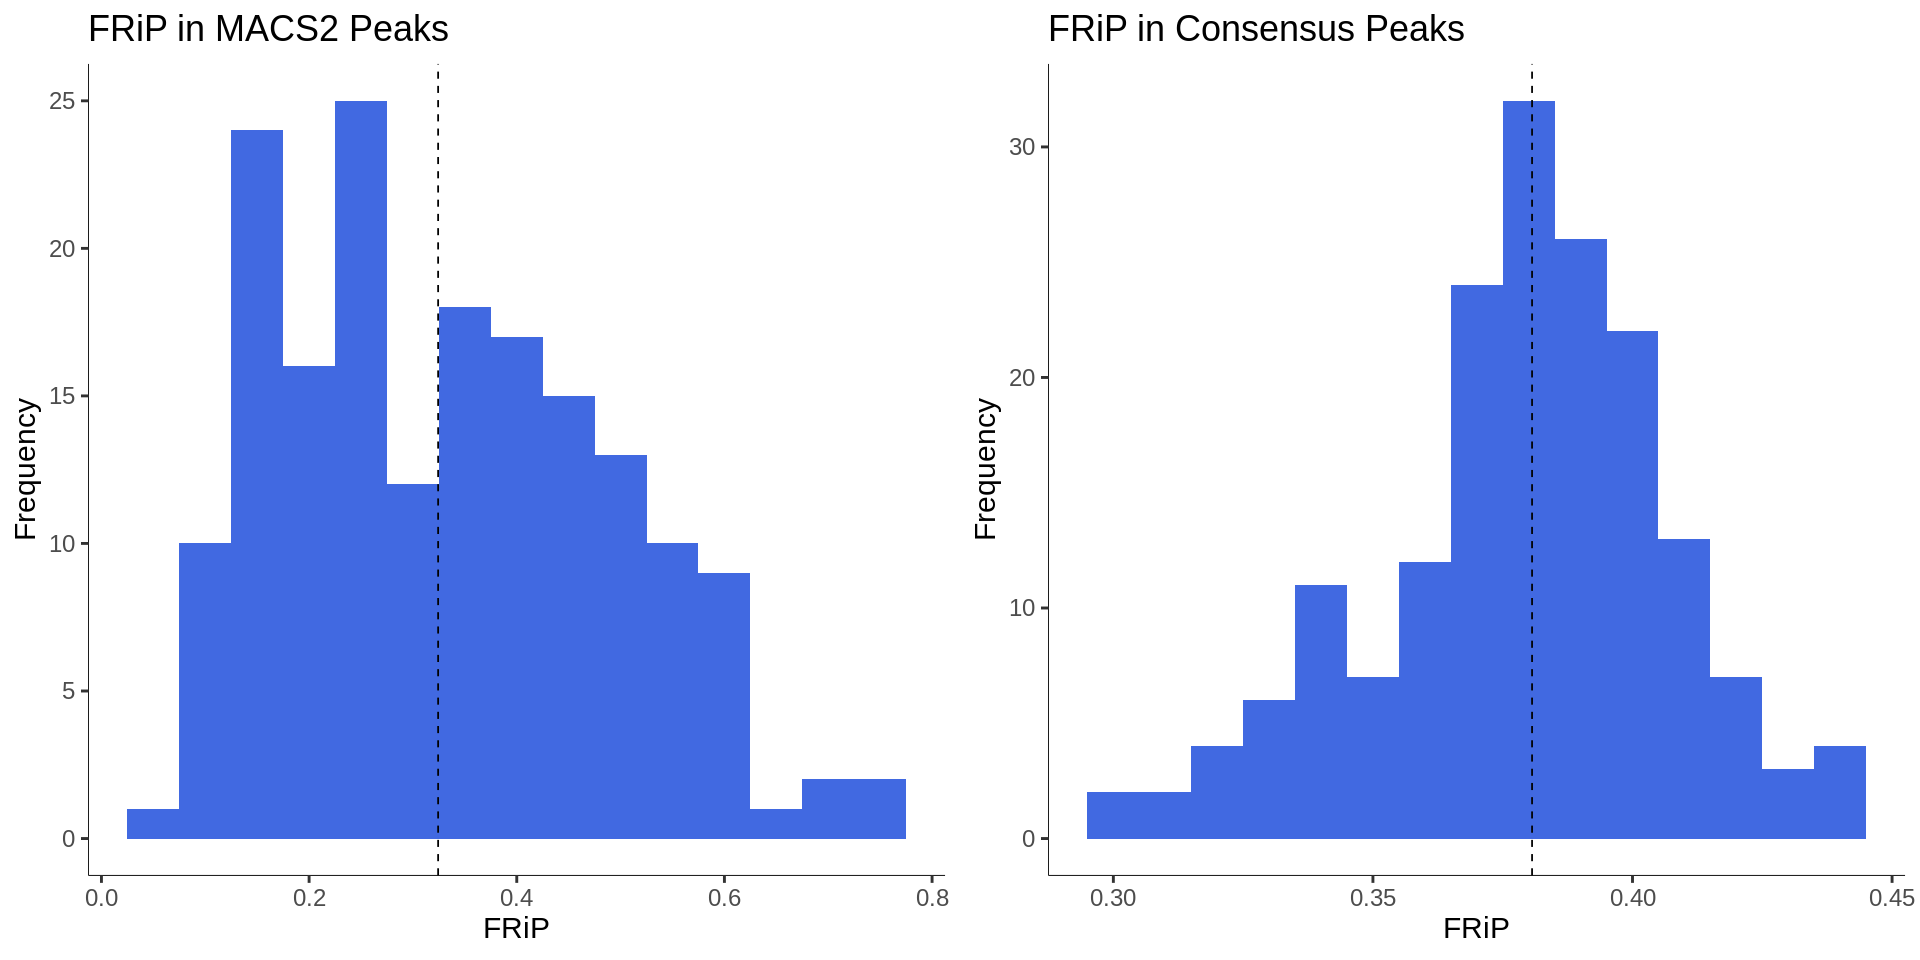

In [17]:
options(repr.plot.width=16, repr.plot.height=8)

p <- ggplot(frip.macs2) +
    geom_histogram(aes(x=FRiP), fill="royalblue", binwidth=0.05) +
    geom_vline(aes(xintercept=median(FRiP)), lty=2) +
    ylab("Frequency") + ggtitle("FRiP in MACS2 Peaks") +
    ggplot_theme

q <- ggplot(frip) +
    geom_histogram(aes(x=FRiP), fill="royalblue", binwidth=0.01) +
    geom_vline(aes(xintercept=median(FRiP)), lty=2) +
    ylab("Frequency") + ggtitle("FRiP in Consensus Peaks") +
    ggplot_theme

plot_grid(p, q)

ggsave("03_Functional_Interpretation/results/peak_frips.svg", width=16, height=8)

### FRiP by Donor

We flagged donor 1003 previously due to low mapping rates during alignment. Comparing FRiP across donors does not show any quality issues specifically associated with donor 1003.

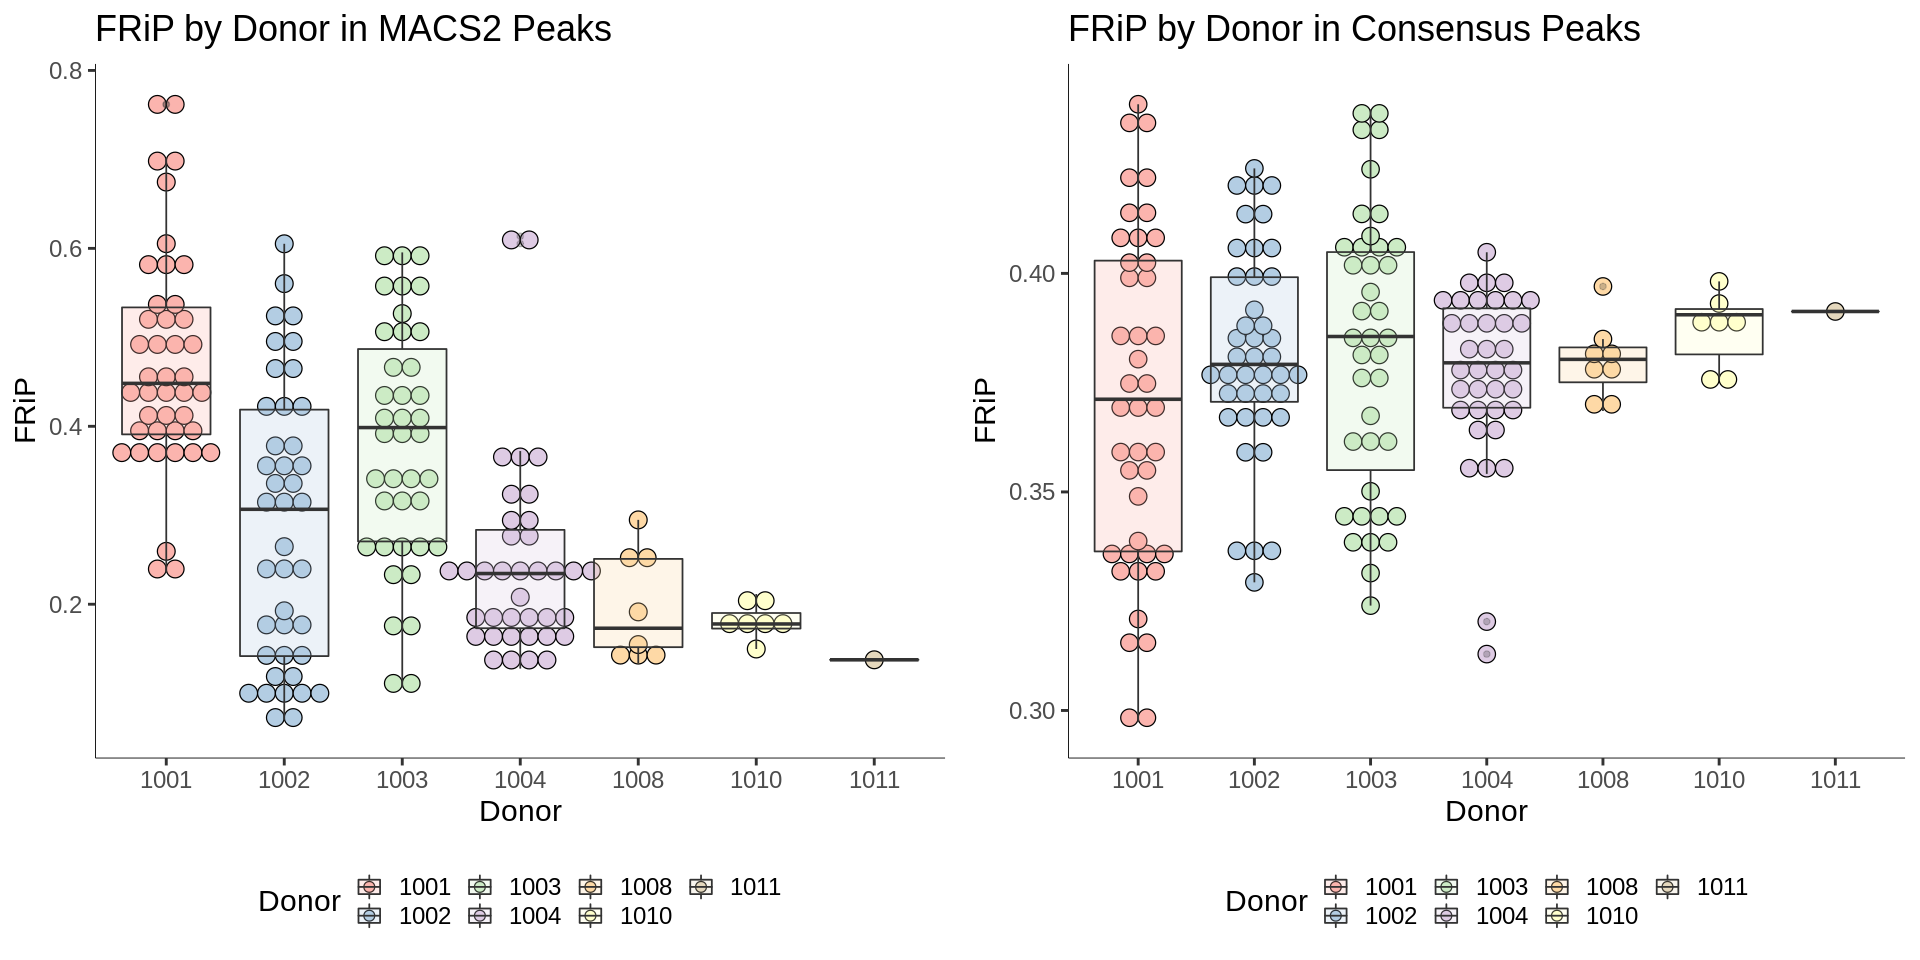

In [18]:
options(repr.plot.width=16, repr.plot.height=8)

p <- merge(frip.macs2, sample.info, by.x="Sample", by.y="Run") %>%
    ggplot(aes(x=Donor, y=FRiP)) +
    geom_dotplot(aes(fill=Donor), binaxis="y", stackdir="center", position=position_dodge(0.75), binwidth=0.02) +
    geom_boxplot(aes(fill=Donor), alpha=0.25) +
    scale_fill_brewer(palette="Pastel1") +
    ggtitle("FRiP by Donor in MACS2 Peaks") +
    ggplot_theme

q <- merge(frip, sample.info, by.x="Sample", by.y="Run") %>%
    ggplot(aes(x=Donor, y=FRiP)) +
    geom_dotplot(aes(fill=Donor), binaxis="y", stackdir="center", position=position_dodge(0.75), binwidth=0.004) +
    geom_boxplot(aes(fill=Donor), alpha=0.25) +
    scale_fill_brewer(palette="Pastel1") +
    ggtitle("FRiP by Donor in Consensus Peaks") +
    ggplot_theme

plot_grid(p, q)

ggsave("03_Functional_Interpretation/results/peak_frips_by_donor.svg", width=16, height=8)

### FRiP for T Cells

T Cells were stimulated with two conditions:

1. **Treatment 1**: CD3/CD28 Co-stimulation for 24 hours
2. **Treatment 2**: IL-2 for 24 hours

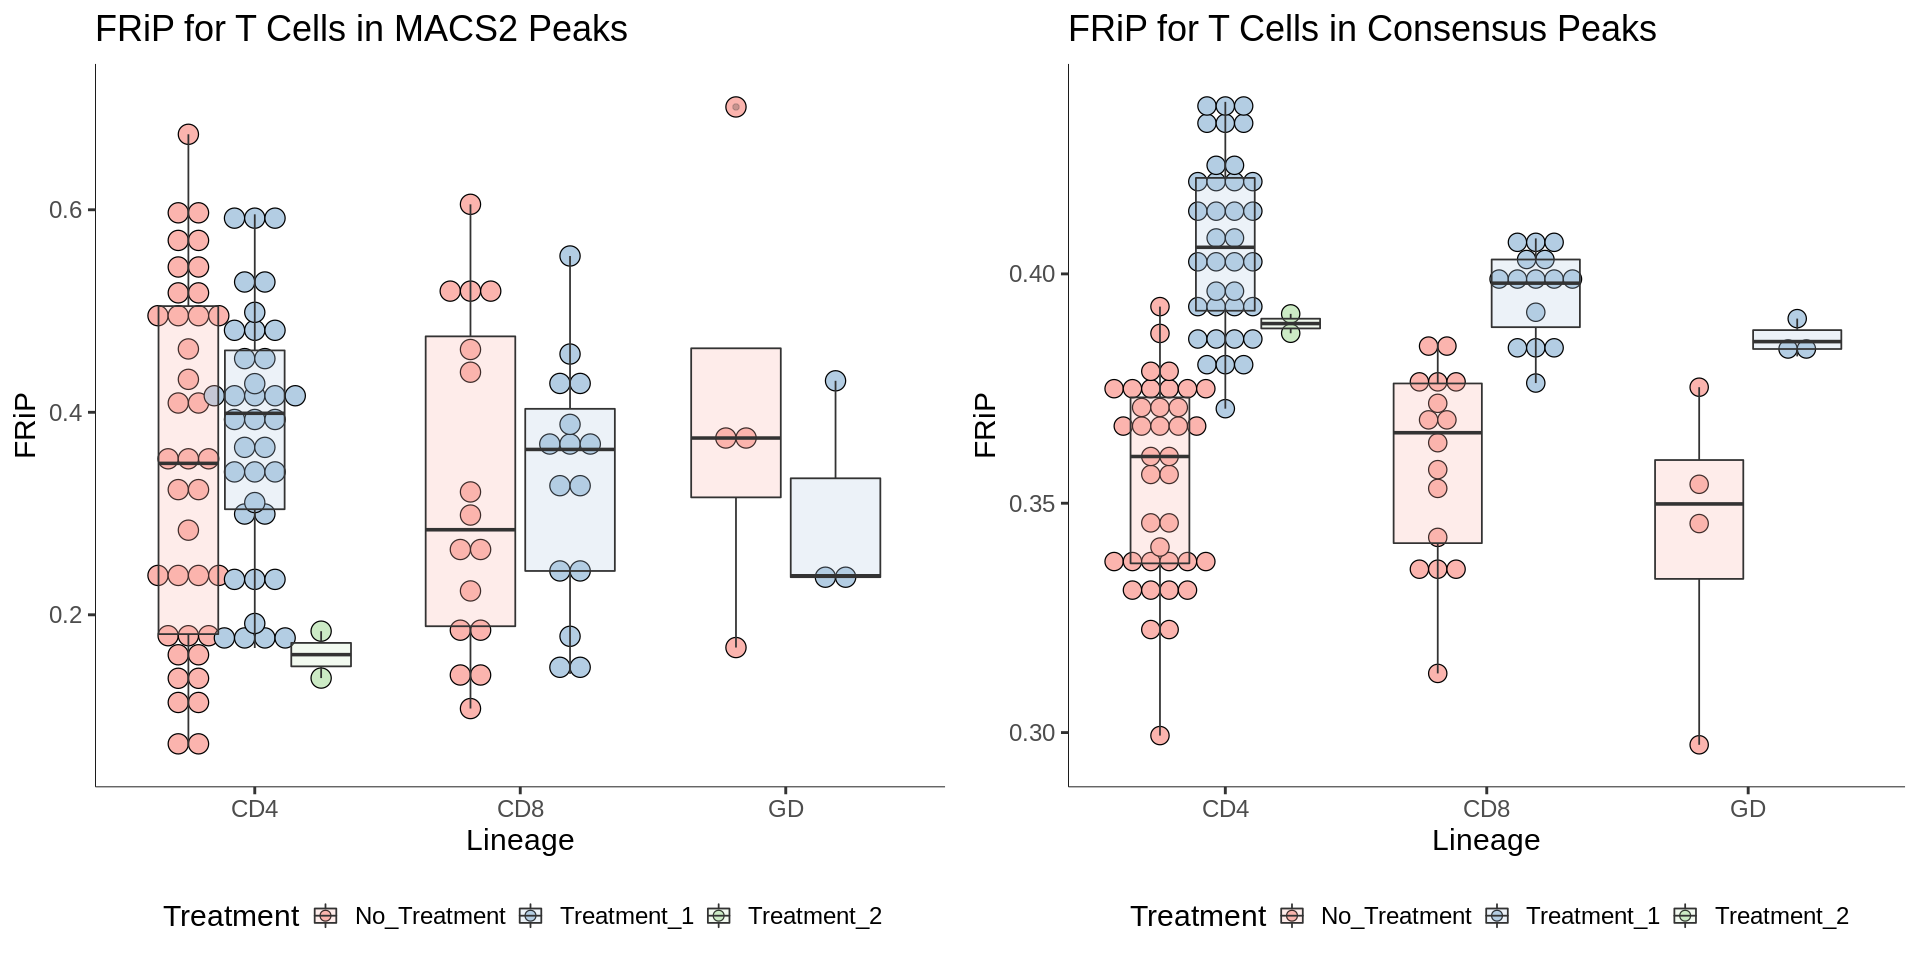

In [19]:
options(repr.plot.width=16, repr.plot.height=8)

p <- merge(frip.macs2, sample.info, by.x="Sample", by.y="Run") %>%
    dplyr::filter(Lineage=="CD4" | Lineage=="CD8" | Lineage=="GD") %>%
    ggplot(aes(x=Lineage, y=FRiP)) +
    geom_dotplot(aes(fill=Treatment), binaxis="y", stackdir="center", position=position_dodge(0.75), binwidth=0.02) +
    geom_boxplot(aes(fill=Treatment), alpha=0.25) +
    scale_fill_brewer(palette="Pastel1") +
    ggtitle("FRiP for T Cells in MACS2 Peaks") +
    ggplot_theme

q <- merge(frip, sample.info, by.x="Sample", by.y="Run") %>%
    dplyr::filter(Lineage=="CD4" | Lineage=="CD8" | Lineage=="GD") %>%
    ggplot(aes(x=Lineage, y=FRiP)) +
    geom_dotplot(aes(fill=Treatment), binaxis="y", stackdir="center", position=position_dodge(0.75), binwidth=0.004) +
    geom_boxplot(aes(fill=Treatment), alpha=0.25) +
    scale_fill_brewer(palette="Pastel1") +
    ggtitle("FRiP for T Cells in Consensus Peaks") +
    ggplot_theme

plot_grid(p, q)

ggsave("03_Functional_Interpretation/results/peak_frips_for_t_cells.svg", width=16, height=8)

### FRiP for B Cells

B Cells were stimulated with two conditions:

1. **Treatment 1**: Anti-IgG/IgM Antibodies for 24 hours
2. **Treatment 2**: IL-4 for 24 hours

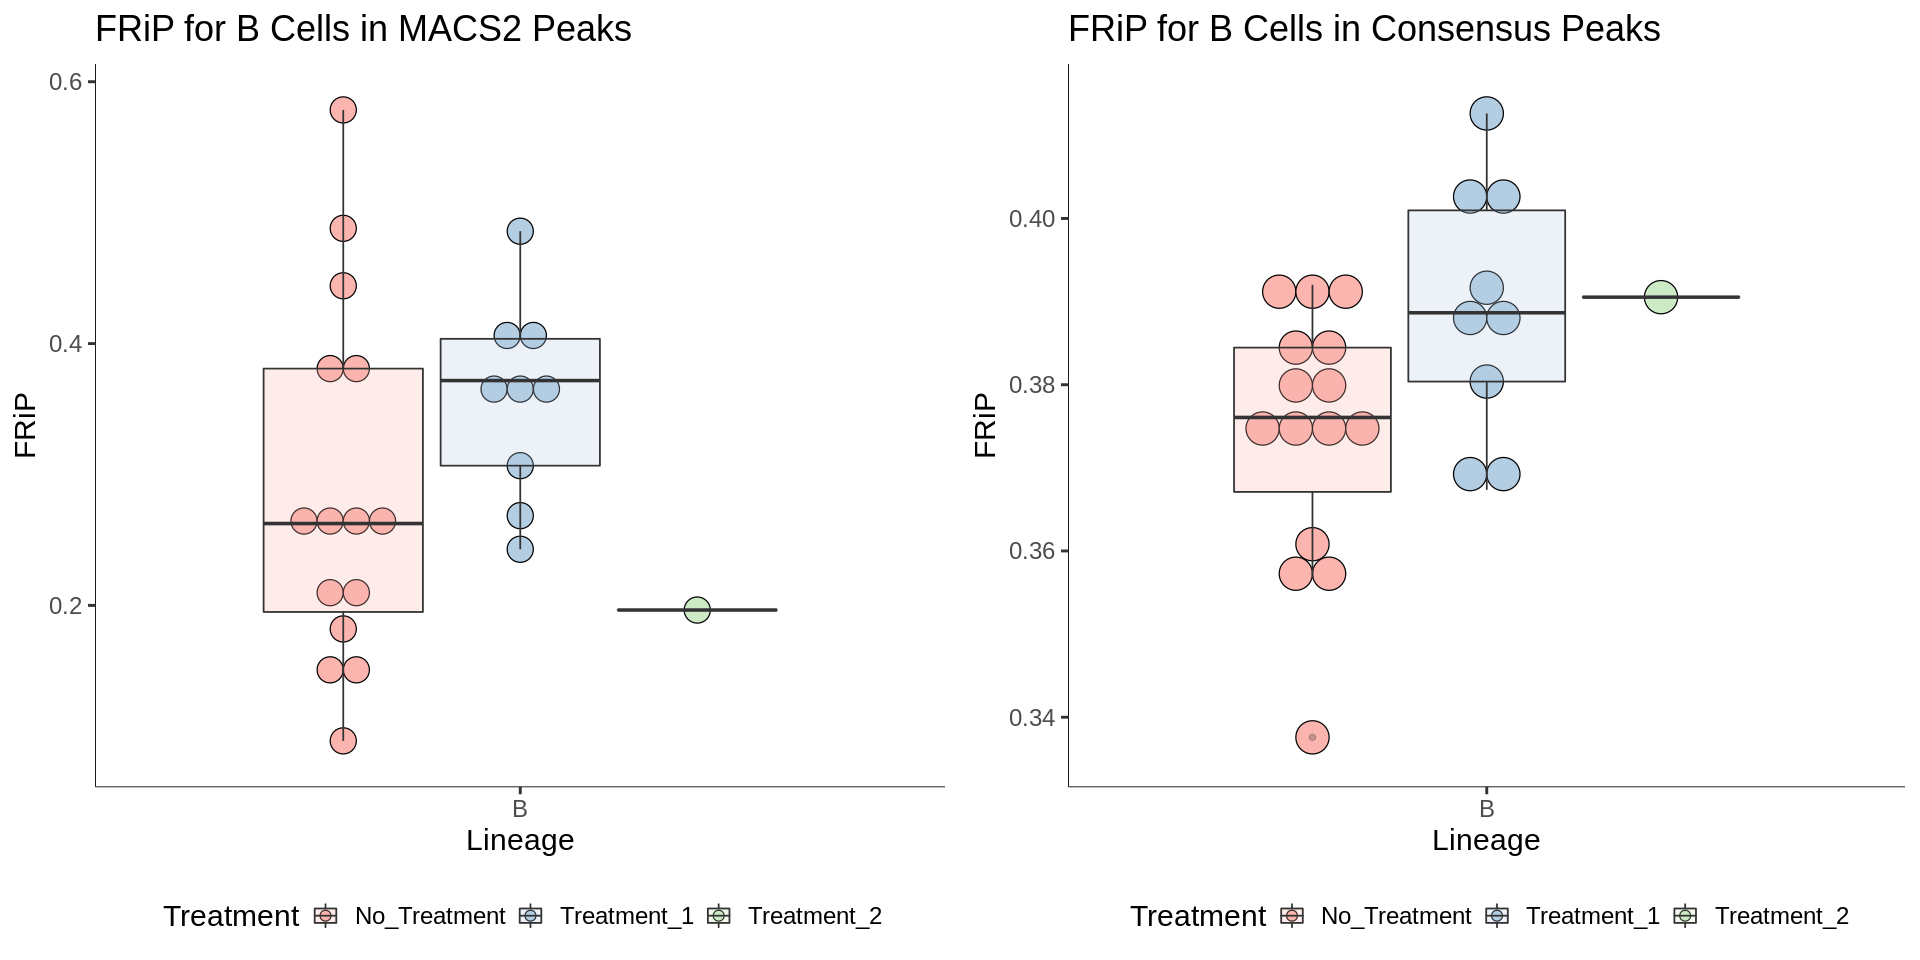

In [20]:
options(repr.plot.width=16, repr.plot.height=8)

p <- merge(frip.macs2, sample.info, by.x="Sample", by.y="Run") %>%
    dplyr::filter(Lineage=="B") %>%
    ggplot(aes(x=Lineage, y=FRiP)) +
    geom_dotplot(aes(fill=Treatment), binaxis="y", stackdir="center", position=position_dodge(0.75), binwidth=0.02) +
    geom_boxplot(aes(fill=Treatment), alpha=0.25) +
    scale_fill_brewer(palette="Pastel1") +
    ggtitle("FRiP for B Cells in MACS2 Peaks") +
    ggplot_theme


q <- merge(frip, sample.info, by.x="Sample", by.y="Run") %>%
    dplyr::filter(Lineage=="B") %>%
    ggplot(aes(x=Lineage, y=FRiP)) +
    geom_dotplot(aes(fill=Treatment), binaxis="y", stackdir="center", position=position_dodge(0.75), binwidth=0.004) +
    geom_boxplot(aes(fill=Treatment), alpha=0.25) +
    scale_fill_brewer(palette="Pastel1") +
    ggtitle("FRiP for B Cells in Consensus Peaks") +
    ggplot_theme

plot_grid(p, q)

ggsave("03_Functional_Interpretation/results/peak_frips_for_b_cells.svg", width=16, height=8)

### FRiP for Monocytes

Monocytes were stimulated with two conditions:

1. **Treatment 1**: LPS (1 $\mu$g/mL) for 24 hours
2. **Treatment 2**: LPS (100 ng/mL) for 6 hours

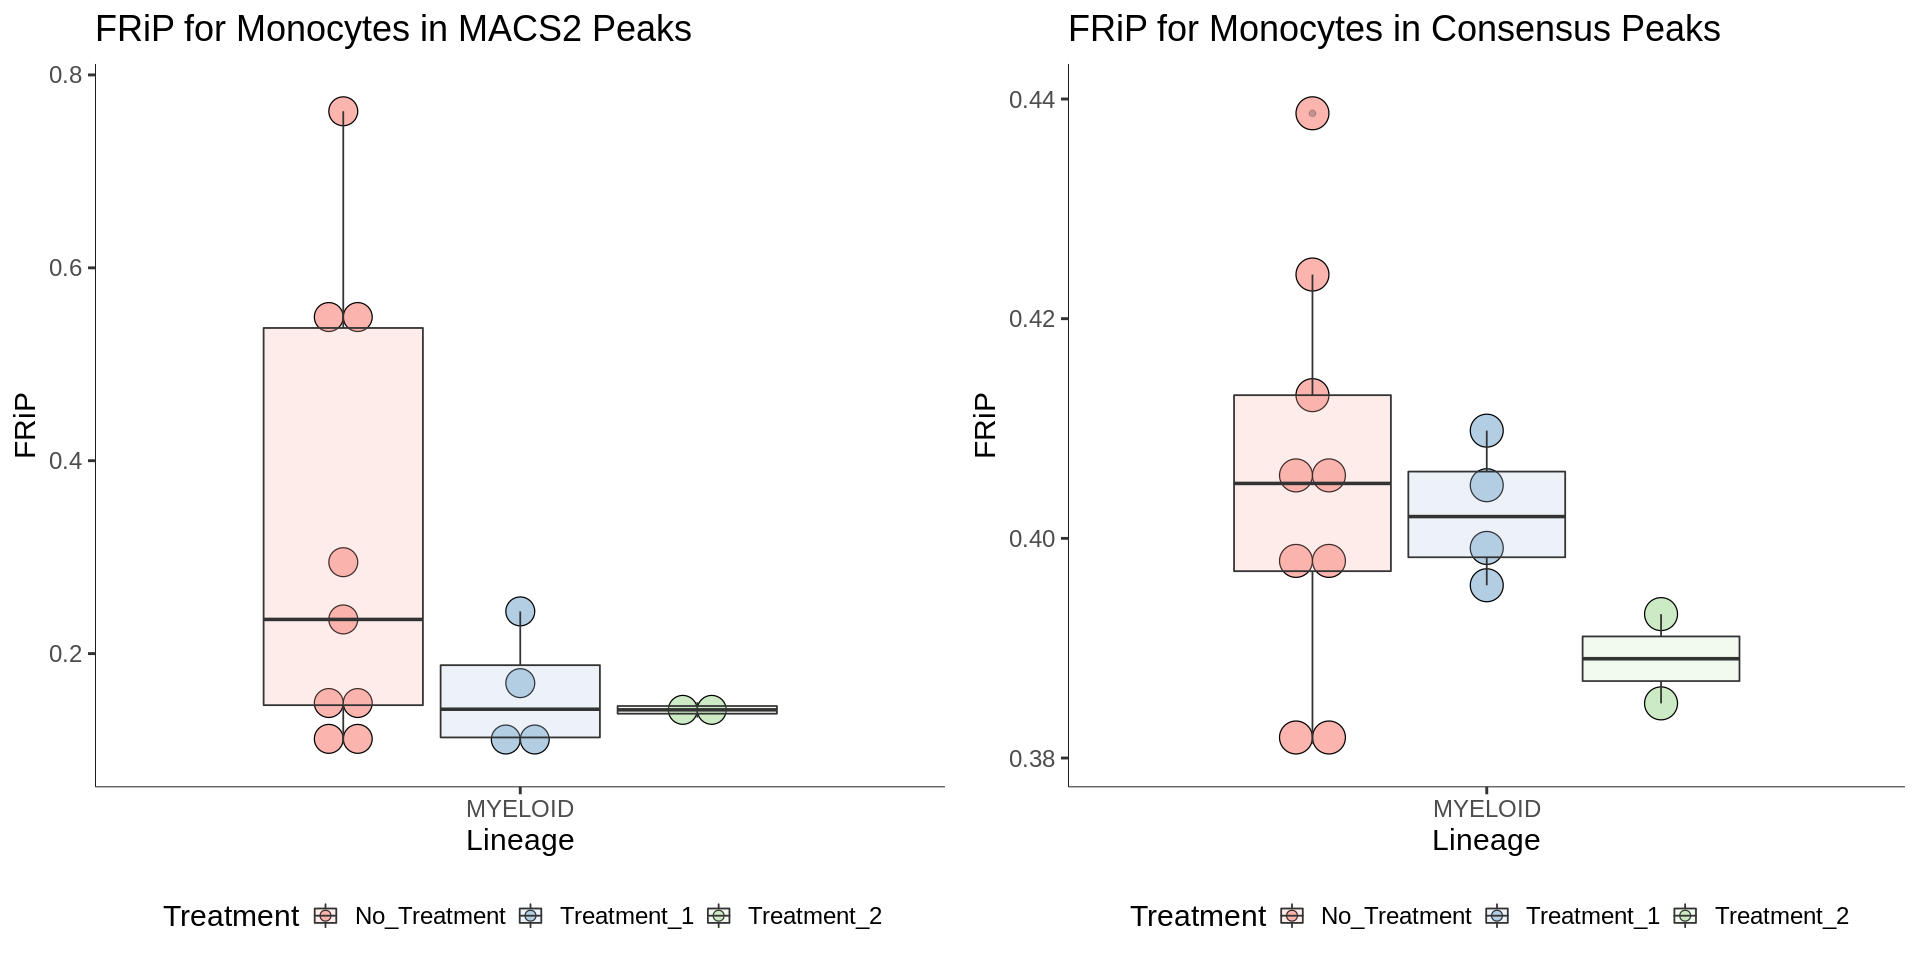

In [21]:
options(repr.plot.width=16, repr.plot.height=8)

p <- merge(frip.macs2, sample.info, by.x="Sample", by.y="Run") %>%
    dplyr::filter(Lineage=="MYELOID") %>%
    ggplot(aes(x=Lineage, y=FRiP)) +
    geom_dotplot(aes(fill=Treatment), binaxis="y", stackdir="center", position=position_dodge(0.75), binwidth=0.03) +
    geom_boxplot(aes(fill=Treatment), alpha=0.25) +
    scale_fill_brewer(palette="Pastel1") +
    ggtitle("FRiP for Monocytes in MACS2 Peaks") +
    ggplot_theme

q <- merge(frip, sample.info, by.x="Sample", by.y="Run") %>%
    dplyr::filter(Lineage=="MYELOID") %>%
    ggplot(aes(x=Lineage, y=FRiP)) +
    geom_dotplot(aes(fill=Treatment), binaxis="y", stackdir="center", position=position_dodge(0.75), binwidth=0.003) +
    geom_boxplot(aes(fill=Treatment), alpha=0.25) +
    scale_fill_brewer(palette="Pastel1") +
    ggtitle("FRiP for Monocytes in Consensus Peaks") +
    ggplot_theme

plot_grid(p, q)

ggsave("03_Functional_Interpretation/results/peak_frips_for_monocytes.svg", width=16, height=8)

### FRiP for NK Cells

NK Cells were stimulated with two conditions:

1. **Treatment 1**: CD2/CD355 beads + IL-2 for 48 hours
2. **Treatment 2**: IL-2 for 24 hours

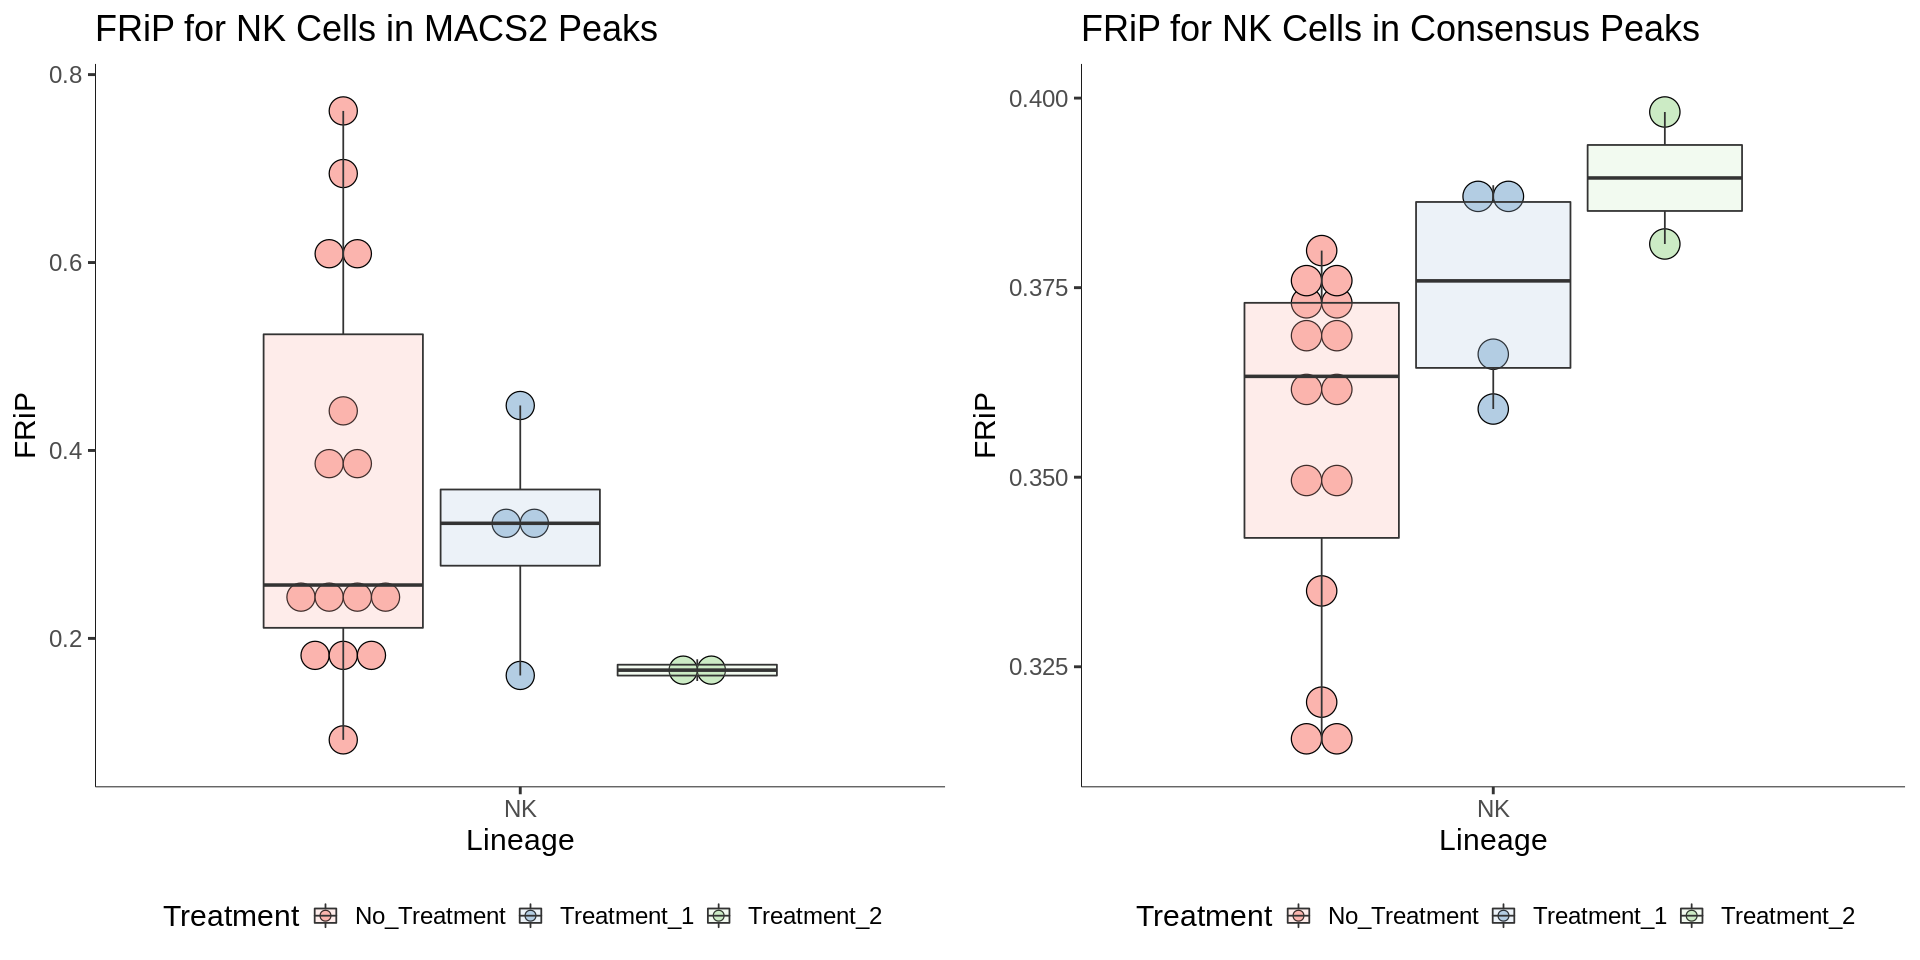

In [22]:
options(repr.plot.width=16, repr.plot.height=8)

p <- merge(frip.macs2, sample.info, by.x="Sample", by.y="Run") %>%
    dplyr::filter(Lineage=="NK") %>%
    ggplot(aes(x=Lineage, y=FRiP)) +
    geom_dotplot(aes(fill=Treatment), binaxis="y", stackdir="center", position=position_dodge(0.75), binwidth=0.03) +
    geom_boxplot(aes(fill=Treatment), alpha=0.25) +
    scale_fill_brewer(palette="Pastel1") +
    ggtitle("FRiP for NK Cells in MACS2 Peaks") +
    ggplot_theme

q <- merge(frip, sample.info, by.x="Sample", by.y="Run") %>%
    dplyr::filter(Lineage=="NK") %>%
    ggplot(aes(x=Lineage, y=FRiP)) +
    geom_dotplot(aes(fill=Treatment), binaxis="y", stackdir="center", position=position_dodge(0.75), binwidth=0.004) +
    geom_boxplot(aes(fill=Treatment), alpha=0.25) +
    scale_fill_brewer(palette="Pastel1") +
    ggtitle("FRiP for NK Cells in Consensus Peaks") +
    ggplot_theme

plot_grid(p, q)

ggsave("03_Functional_Interpretation/results/peak_frips_for_nk_cells.svg", width=16, height=8)

### FRiP by Lineage

The FRiP scores in Myeloid cells are much higher than in the rest. The FRiP scores in NK cells are slightly lower than the rest.

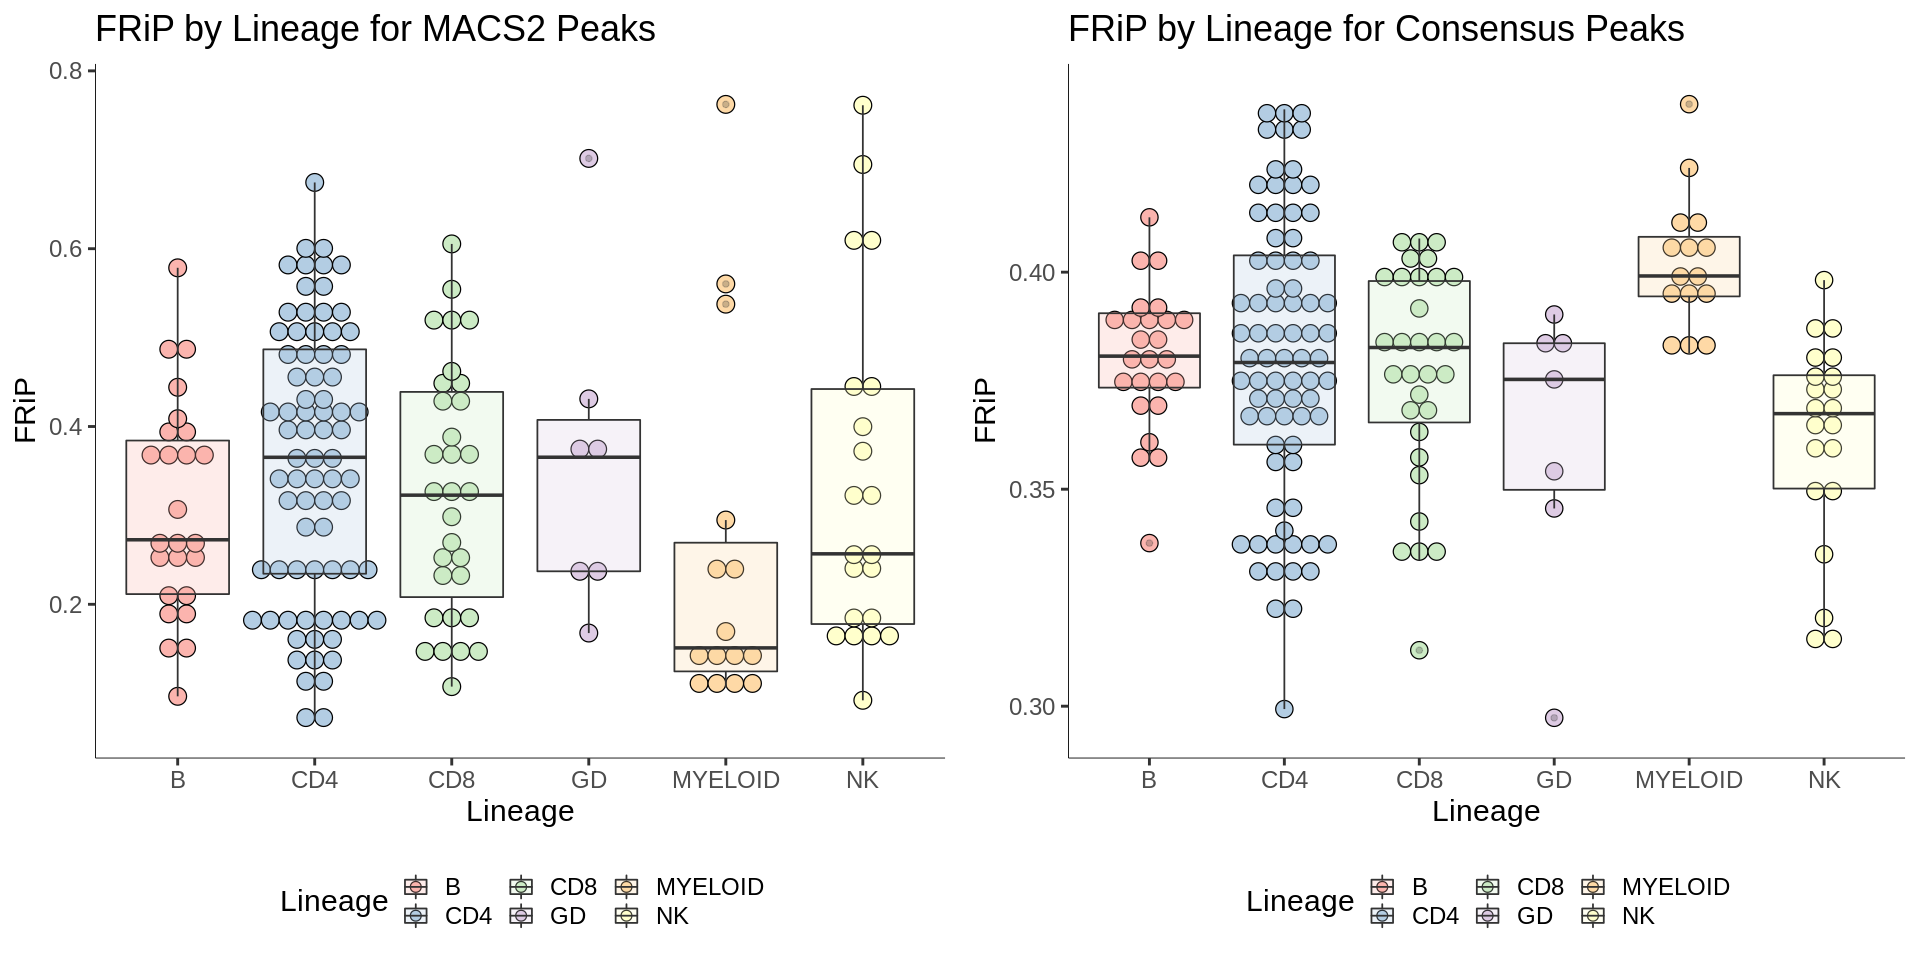

In [23]:
options(repr.plot.width=16, repr.plot.height=8)

p <- merge(frip.macs2, sample.info, by.x="Sample", by.y="Run") %>%
    ggplot(aes(x=Lineage, y=FRiP)) +
    geom_dotplot(aes(fill=Lineage), binaxis="y", stackdir="center", position=position_dodge(0.75), binwidth=0.02) +
    geom_boxplot(aes(fill=Lineage), alpha=0.25) +
    scale_fill_brewer(palette="Pastel1") +
    ggtitle("FRiP by Lineage for MACS2 Peaks") +
    ggplot_theme

q <- merge(frip, sample.info, by.x="Sample", by.y="Run") %>%
    ggplot(aes(x=Lineage, y=FRiP)) +
    geom_dotplot(aes(fill=Lineage), binaxis="y", stackdir="center", position=position_dodge(0.75), binwidth=0.004) +
    geom_boxplot(aes(fill=Lineage), alpha=0.25) +
    scale_fill_brewer(palette="Pastel1") +
    ggtitle("FRiP by Lineage for Consensus Peaks") +
    ggplot_theme

plot_grid(p, q)

ggsave("03_Functional_Interpretation/results/peak_frips_by_lineage.svg", width=16, height=8)

## FRiP Association with Peak Counts

Are FRiP scores for individual samples associated with the number of peaks detected in the sample?

### MACS2 Peaks

The strength of the association, as measured using Spearman's Rho, is $\rho\approx 0.267$.

In [24]:
n.peaks <- peak.widths %>%
    as.data.frame() %>%
    dplyr::group_by(Sample) %>%
    dplyr::summarize(N.Peaks=n()) %>%
    merge(., frip.macs2, by="Sample") %>%
    merge(., sample.info, by.x="Sample", by.y="Run")

cor(n.peaks$N.Peaks, n.peaks$FRiP, method="spearman")

[1] 0.2669413

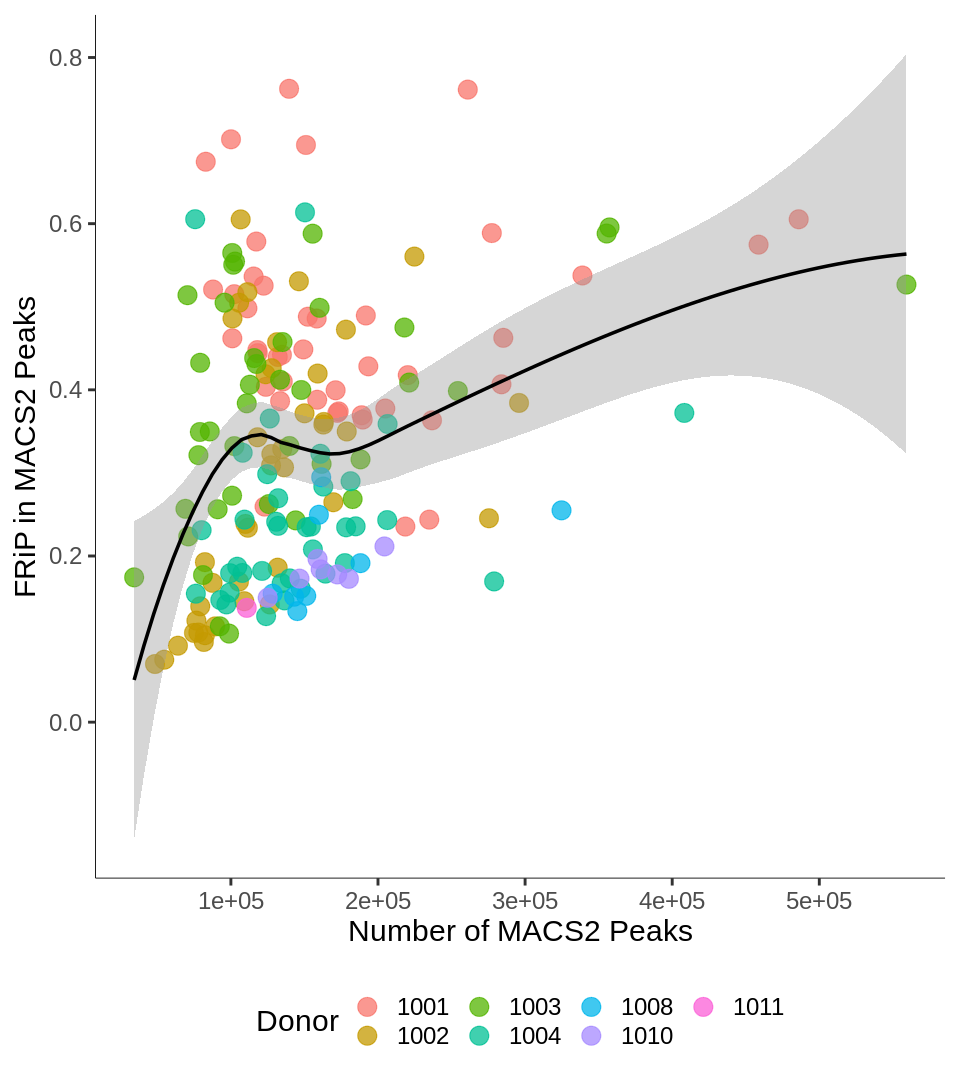

In [25]:
options(repr.plot.width=8, repr.plot.height=9)
n.peaks %>%
    ggplot(aes(x=N.Peaks, y=FRiP)) +
    geom_point(aes(color=Donor), size=I(5), alpha=0.75) +
    geom_smooth(method="loess", formula=y~x, color="black") +
    xlab("Number of MACS2 Peaks") + ylab("FRiP in MACS2 Peaks") +
    ggplot_theme
ggsave("03_Functional_Interpretation/results/macs2_frip_peak_count.svg", width=8, height=9)

### Consensus Peaks

The strength of the association, as measured using Spearman's Rho, is $\rho\approx 0.502$.

In [26]:
n.peaks <- colSums(peak.coverage[,-(1:3)] > 0) %>%
    as.data.frame() %>%
    dplyr::select(N.Peaks=1) %>%
    dplyr::mutate(Sample=rownames(.)) %>%
    merge(., frip, by="Sample") %>%
    merge(., sample.info, by.x="Sample", by.y="Run")

cor(n.peaks$N.Peaks, n.peaks$FRiP, method="spearman")

[1] 0.5024048

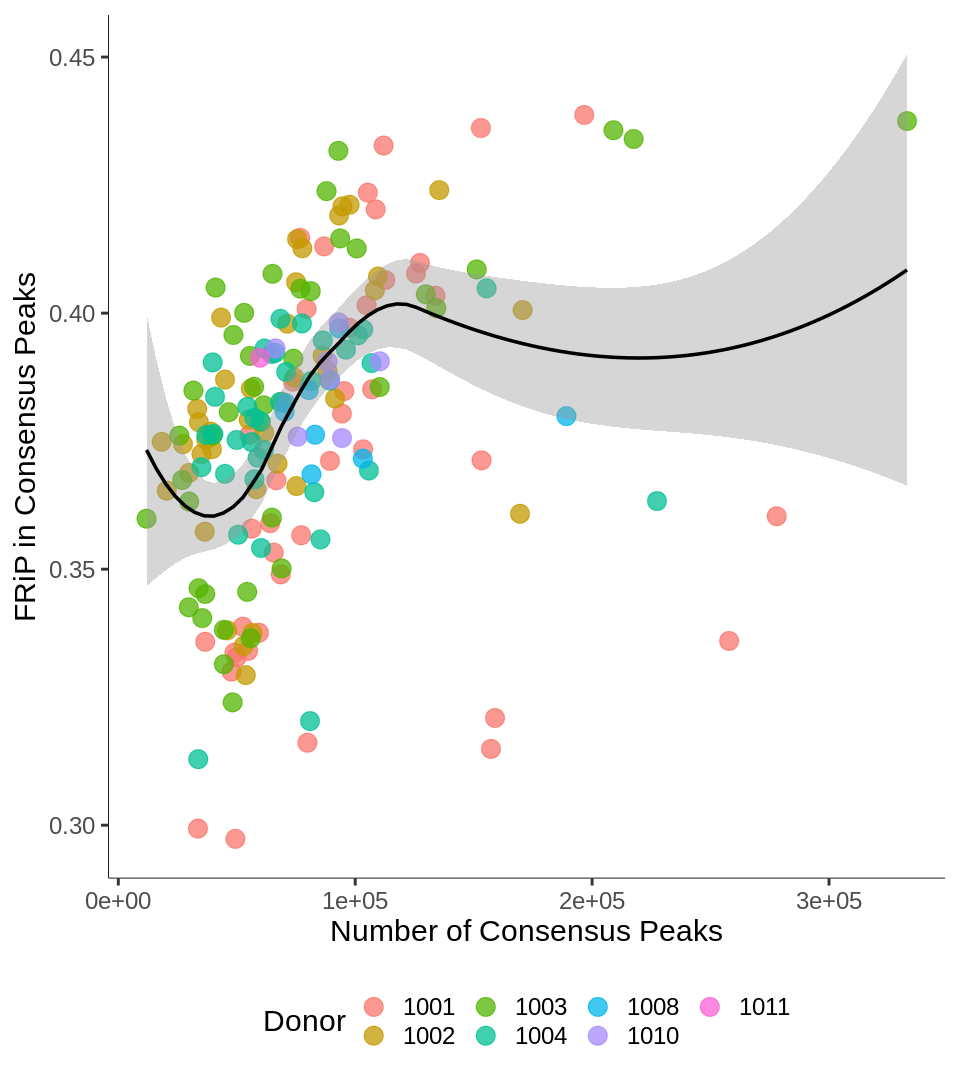

In [27]:
options(repr.plot.width=8, repr.plot.height=9)
n.peaks %>%
    ggplot(aes(x=N.Peaks, y=FRiP)) +
    geom_point(aes(color=Donor), size=I(5), alpha=0.75) +
    geom_smooth(method="loess", formula=y~x, color="black") +
    xlab("Number of Consensus Peaks") + ylab("FRiP in Consensus Peaks") +
    ggplot_theme
ggsave("03_Functional_Interpretation/results/frip_peak_count.svg", width=8, height=9)

## TSS Enrichment Scores

TSS Enrichment score is calculated as follows:

1. Take the aggregate number of reads mapping to 2kb away from TSSs
2. Take the aggregate number of reads mapping within a 100bp window at TSSs
3. Calculate the fold increase in read coverage at the TSS compared to the 2kb flanking regions

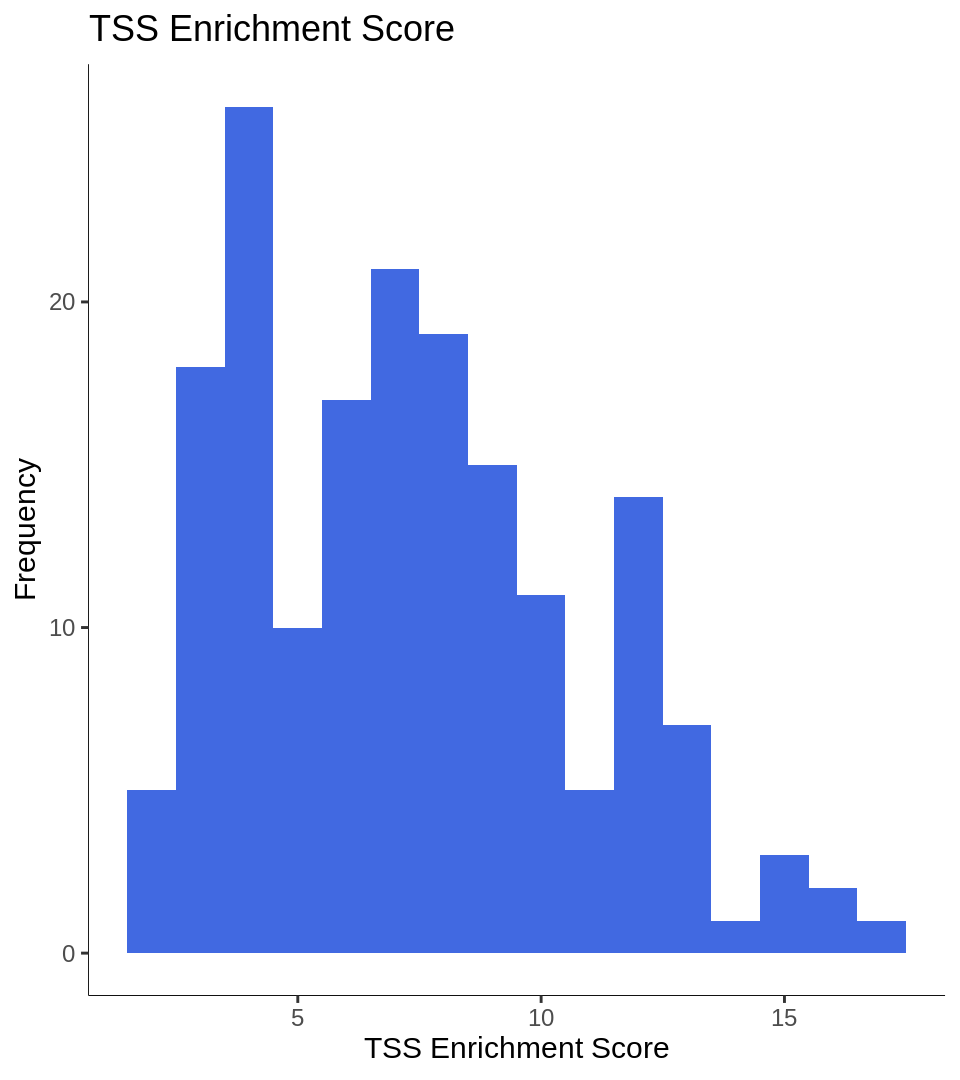

In [34]:
options(repr.plot.width=8, repr.plot.height=9)

ggplot(tss.enrichment) +
    geom_histogram(aes(x=TSS_Enrichment_Score), binwidth=1, fill="royalblue") +
    xlab("TSS Enrichment Score") + ylab("Frequency") +
    ggtitle("TSS Enrichment Score") +
    ggplot_theme

ggsave("03_Functional_Interpretation/results/tss_enrichment_scores.svg", width=8, height=9)

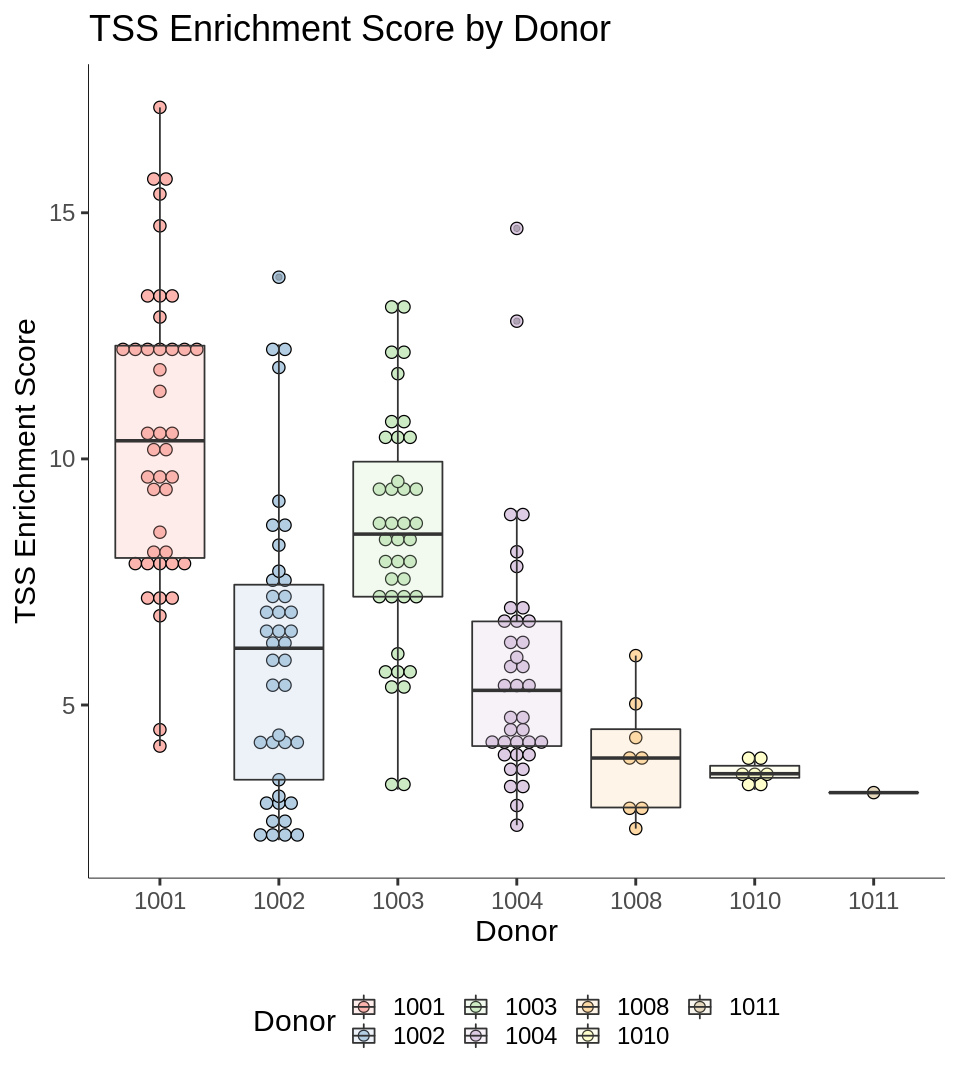

In [44]:
options(repr.plot.width=8, repr.plot.height=9)

merge(tss.enrichment, sample.info, by.x="Sample", by.y="Run") %>%
    ggplot(aes(x=Donor, y=TSS_Enrichment_Score)) + 
    geom_dotplot(aes(fill=Donor), binaxis="y", stackdir="center", position=position_dodge(0.75), binwidth=0.25) +
    geom_boxplot(aes(fill=Donor), alpha=0.25) +
    scale_fill_brewer(palette="Pastel1") +
    ylab("TSS Enrichment Score") +
    ggtitle("TSS Enrichment Score by Donor") +
    ggplot_theme

ggsave("03_Functional_Interpretation/results/tss_enrichment_scores_by_donor.svg", width=8, height=9)

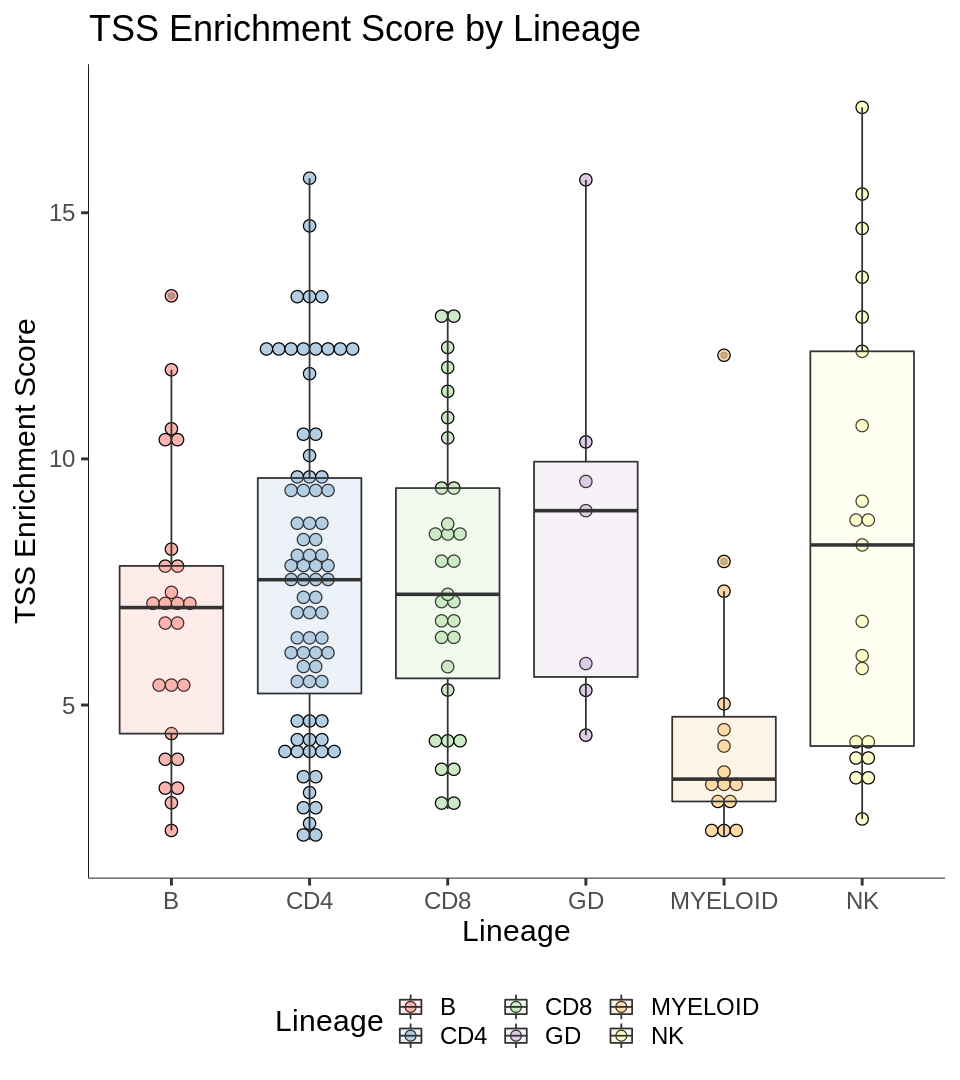

In [45]:
options(repr.plot.width=8, repr.plot.height=9)

merge(tss.enrichment, sample.info, by.x="Sample", by.y="Run") %>%
    ggplot(aes(x=Lineage, y=TSS_Enrichment_Score)) + 
    geom_dotplot(aes(fill=Lineage), binaxis="y", stackdir="center", position=position_dodge(0.75), binwidth=0.25) +
    geom_boxplot(aes(fill=Lineage), alpha=0.25) +
    scale_fill_brewer(palette="Pastel1") +
    ylab("TSS Enrichment Score") +
    ggtitle("TSS Enrichment Score by Lineage") +
    ggplot_theme

ggsave("03_Functional_Interpretation/results/tss_enrichment_scores_by_lineage.svg", width=8, height=9)

## Peak Counts

In [28]:
set.seed(13987395)
tsne.res <- Rtsne(log10(t(peak.counts[,-(1:5)]) + 0.5), num_threads=4, perplexity=10)

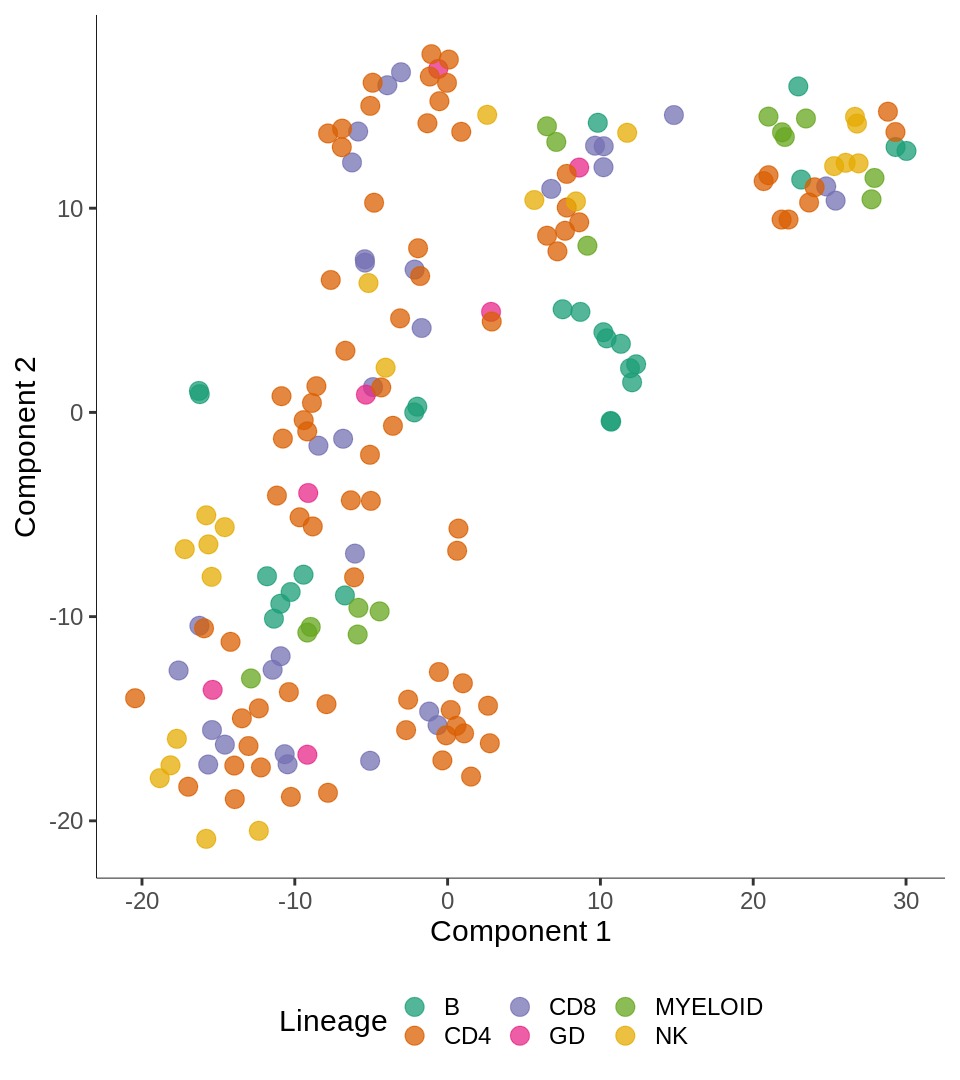

In [29]:
tsne.res$Y %>%
    as.data.frame() %>%
    dplyr::select(Comp1=1, Comp2=2) %>%
    dplyr::mutate(Run=colnames(peak.counts)[-(1:5)]) %>%
    merge(., sample.info, by="Run") %>%
    ggplot() +
    geom_point(aes(x=Comp1, y=Comp2, color=Lineage), size=I(5), alpha=0.75) +
    scale_color_brewer(palette="Dark2") +
    xlab("Component 1") + ylab("Component 2") +
    ggplot_theme